<a href="https://colab.research.google.com/github/saipklvs/rlLearningExamplesBook/blob/master/TFGNN_Football.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#!pip install tensorflow_gnn

In [ ]:
#!pip install basemap

# TF-GNN Football Example
##### The dataset is a network of universities and the football games they played against each other. Each school node has a conference which we will be trying to predict. I also create a feature indicating if a game is an in-conference game for making edge predictions as well.
### Imports

In [ ]:
import pandas as pd
import numpy as np
import networkx as nx
import tensorflow as tf
import tensorflow_gnn as tfgnn
import urllib.request
import matplotlib.pyplot as plt
import io
import zipfile
import sys

from difflib import SequenceMatcher
from mpl_toolkits.basemap import Basemap
from sklearn.model_selection import train_test_split
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials

### Data Download

In [ ]:
url = "http://www-personal.umich.edu/~mejn/netdata/football.zip"
sock = urllib.request.urlopen(url)  # open URL
s = io.BytesIO(sock.read())  # read into BytesIO "file"
sock.close()

zf = zipfile.ZipFile(s)  # zipfile object
txt = zf.read("football.txt").decode()  # read info file
gml = zf.read("football.gml").decode()  # read gml data
# throw away bogus first line with # from mejn files
gml = gml.split("\n")[1:]
G = nx.parse_gml(gml)  # parse gml data
print(txt)

The file football.gml contains the network of American football games
between Division IA colleges during regular season Fall 2000, as compiled
by M. Girvan and M. Newman.  The nodes have values that indicate to which
conferences they belong.  The values are as follows:

  0 = Atlantic Coast
  1 = Big East
  2 = Big Ten
  3 = Big Twelve
  4 = Conference USA
  5 = Independents
  6 = Mid-American
  7 = Mountain West
  8 = Pacific Ten
  9 = Southeastern
 10 = Sun Belt
 11 = Western Athletic

If you make use of these data, please cite M. Girvan and M. E. J. Newman,
Community structure in social and biological networks,
Proc. Natl. Acad. Sci. USA 99, 7821-7826 (2002).

Correction: Two edges were erroneously duplicated in this data set, and
have been removed (21 SEP 2014)



### Visualization

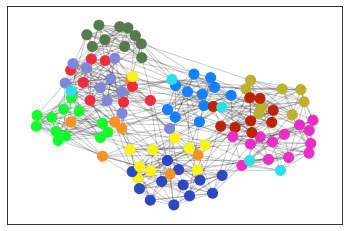

In [ ]:
cmap = {0:'#bd2309', 1:'#bbb12d',2:'#1480fa',3:'#14fa2f',4:'#faf214',
        5:'#2edfea',6:'#ea2ec4',7:'#ea2e40',8:'#577a4d',9:'#2e46c0',
        10:'#f59422',11:'#8086d9'}

colors = [cmap[G.nodes[n]['value']] for n in G.nodes()]
pos = nx.spring_layout(G, seed=1987)

nx.draw_networkx_edges(G, pos, alpha=0.2)
nx.draw_networkx_nodes(G, pos, nodelist=G.nodes(),
                       node_color=colors, node_size=100)

# Data
### Extract Node & Edge Dataframes

In [ ]:

node_df = pd.DataFrame.from_dict(dict(G.nodes(data=True)), orient='index')
node_df.index.name = 'school'
node_df.columns = ['conference']

edge_df = nx.to_pandas_edgelist(G)

### Add Node Features
##### Add lat-long coordinates, and previous year rank, wins, and conference wins

In [ ]:
node_data = {'AirForce': {'Latitude': 38.996093, 'Longitude': -104.857222, 'Rank': 83, 'Wins': 6, 'Conf_wins': 2},
             'Akron': {'Latitude': 41.075346, 'Longitude': -81.512184, 'Rank': 66, 'Wins': 7, 'Conf_wins': 5},
             'Alabama': {'Latitude': 33.215775, 'Longitude': -87.538261, 'Rank': 101, 'Wins': 10, 'Conf_wins': 7},
             'AlabamaBirmingham': {'Latitude': 33.501569, 'Longitude': -86.805677, 'Rank': 52, 'Wins': 5, 'Conf_wins': 4},
             'Arizona': {'Latitude': 32.248814, 'Longitude': -110.987419, 'Rank': 90, 'Wins': 6, 'Conf_wins': 3}, 
             'ArizonaState': {'Latitude': 33.424564, 'Longitude': -111.928001, 'Rank': 88, 'Wins': 6, 'Conf_wins': 5},
             'Arkansas': {'Latitude': 36.068213, 'Longitude': -94.1748, 'Rank': 103, 'Wins': 8, 'Conf_wins': 4},
             'ArkansasState': {'Latitude': 35.842722, 'Longitude': -90.674584, 'Rank': 45, 'Wins': 4, 'Conf_wins': 2},
             'Army': {'Latitude': 39.343777, 'Longitude': -94.915748, 'Rank': 54, 'Wins': 3, 'Conf_wins': 1},
             'Auburn': {'Latitude': 32.593357, 'Longitude': -85.495163, 'Rank': 105, 'Wins': 5, 'Conf_wins': 2},
             'BallState': {'Latitude': 40.207953, 'Longitude': -85.413456, 'Rank': 76, 'Wins': 0, 'Conf_wins': 0},
             'Baylor': {'Latitude': 31.549612, 'Longitude': -97.114885, 'Rank': 21, 'Wins': 1, 'Conf_wins': 0},
             'BoiseState': {'Latitude': 43.6036, 'Longitude': -116.20871, 'Rank': 41, 'Wins': 10, 'Conf_wins': 5},
             'BostonCollege': {'Latitude': 42.350876, 'Longitude': -71.106918, 'Rank': 24, 'Wins': 8, 'Conf_wins': 4},
             'BowlingGreenState': {'Latitude': 41.379698, 'Longitude': -83.630737, 'Rank': 68, 'Wins': 5, 'Conf_wins': 3},
             'BrighamYoung': {'Latitude': 40.251475, 'Longitude': -111.649241, 'Rank': 78, 'Wins': 8, 'Conf_wins': 5},
             'Buffalo': {'Latitude': 43.000291, 'Longitude': -78.789165, 'Rank': 70, 'Wins': 0, 'Conf_wins': 0},
             'California': {'Latitude': 37.871853, 'Longitude': -122.258423, 'Rank': 92, 'Wins': 4, 'Conf_wins': 3},
             'CentralFlorida': {'Latitude': 28.602378, 'Longitude': -81.20025, 'Rank': 61, 'Wins': 4, 'Conf_wins': 0},
             'CentralMichigan': {'Latitude': 43.590972, 'Longitude': -84.776213, 'Rank': 75, 'Wins': 4, 'Conf_wins': 3},
             'Cincinnati': {'Latitude': 39.132827, 'Longitude': -84.514935, 'Rank': 56, 'Wins': 3, 'Conf_wins': 0},
             'Clemson': {'Latitude': 34.673227, 'Longitude': -82.836745, 'Rank': 4, 'Wins': 6, 'Conf_wins': 5},
             'Colorado': {'Latitude': 40.006638, 'Longitude': -105.267476, 'Rank': 12, 'Wins': 7, 'Conf_wins': 5},
             'ColoradoState': {'Latitude': 40.573181, 'Longitude': -105.086386, 'Rank': 79, 'Wins': 8, 'Conf_wins': 5},
             'Connecticut': {'Latitude': 41.807281, 'Longitude': -72.254646, 'Rank': 115, 'Wins': 4, 'Conf_wins': 3},
             'Duke': {'Latitude': 36.001465, 'Longitude': -78.939133, 'Rank': 7, 'Wins': 3, 'Conf_wins': 3},
             'EastCarolina': {'Latitude': 35.60684, 'Longitude': -77.366564, 'Rank': 49, 'Wins': 9, 'Conf_wins': 4},
             'EasternMichigan': {'Latitude': 42.250631, 'Longitude': -83.624152, 'Rank': 74, 'Wins': 4, 'Conf_wins': 4},
             'Florida': {'Latitude': 29.643946, 'Longitude': -82.355659, 'Rank': 95, 'Wins': 9, 'Conf_wins': 7},
             'FloridaState': {'Latitude': 30.441805, 'Longitude': -84.298521, 'Rank': 1, 'Wins': 12, 'Conf_wins': 8},
             'FresnoState': {'Latitude': 36.811754, 'Longitude': -119.748511, 'Rank': 109, 'Wins': 8, 'Conf_wins': 5},
             'Georgia': {'Latitude': 33.948006, 'Longitude': -83.377319, 'Rank': 97, 'Wins': 8, 'Conf_wins': 5},
             'GeorgiaTech': {'Latitude': 33.775529, 'Longitude': -84.396311, 'Rank': 2, 'Wins': 8, 'Conf_wins': 5},
             'Hawaii': {'Latitude': 19.699575, 'Longitude': -155.080872, 'Rank': 107, 'Wins': 9, 'Conf_wins': 5},
             'Houston': {'Latitude': 29.766083, 'Longitude': -95.35881, 'Rank': 53, 'Wins': 7, 'Conf_wins': 3},
             'Idaho': {'Latitude': 46.728709, 'Longitude': -117.012675, 'Rank': 42, 'Wins': 7, 'Conf_wins': 4},
             'Illinois': {'Latitude': 40.110558, 'Longitude': -88.228333, 'Rank': 35, 'Wins': 8, 'Conf_wins': 4},
             'Indiana': {'Latitude': 39.16806, 'Longitude': -86.522485, 'Rank': 38, 'Wins': 4, 'Conf_wins': 3},
             'Iowa': {'Latitude': 41.662607, 'Longitude': -91.55496, 'Rank': 40, 'Wins': 1, 'Conf_wins': 0},
             'IowaState': {'Latitude': 42.026511, 'Longitude': -93.646396, 'Rank': 14, 'Wins': 4, 'Conf_wins': 1},
             'Kansas': {'Latitude': 38.954343, 'Longitude': -95.255805, 'Rank': 13, 'Wins': 5, 'Conf_wins': 3},
             'KansasState': {'Latitude': 39.197221, 'Longitude': -96.585268, 'Rank': 11, 'Wins': 11, 'Conf_wins': 7},
             'Kent': {'Latitude': 41.149219, 'Longitude': -81.344644, 'Rank': 69, 'Wins': 2, 'Conf_wins': 2},
             'Kentucky': {'Latitude': 38.030602, 'Longitude': -84.50401, 'Rank': 98, 'Wins': 6, 'Conf_wins': 4},
             'LouisianaLafayette': {'Latitude': 30.211892, 'Longitude': -92.019939, 'Rank': 63, 'Wins': 2, 'Conf_wins': 0},
             'LouisianaMonroe': {'Latitude': 32.531076, 'Longitude': -92.067332, 'Rank': 58, 'Wins': 5, 'Conf_wins': 0},
             'LouisianaState': {'Latitude': 30.412331, 'Longitude': -91.183701, 'Rank': 106, 'Wins': 3, 'Conf_wins': 1},
             'LouisianaTech': {'Latitude': 32.530628, 'Longitude': -92.652078, 'Rank': 57, 'Wins': 8, 'Conf_wins': 0},
             'Louisville': {'Latitude': 38.21224, 'Longitude': -85.7589, 'Rank': 50, 'Wins': 7, 'Conf_wins': 4},
             'Marshall': {'Latitude': 38.42339, 'Longitude': -82.425003, 'Rank': 64, 'Wins': 13, 'Conf_wins': 8},
             'Maryland': {'Latitude': 38.987227, 'Longitude': -76.94249, 'Rank': 8, 'Wins': 5, 'Conf_wins': 2},
             'Memphis': {'Latitude': 35.118619, 'Longitude': -89.937385, 'Rank': 51, 'Wins': 5, 'Conf_wins': 4},
             'MiamiFlorida': {'Latitude': 25.717512, 'Longitude': -80.277861, 'Rank': 23, 'Wins': 9, 'Conf_wins': 6},
             'MiamiOhio': {'Latitude': 39.50831, 'Longitude': -84.734878, 'Rank': 65, 'Wins': 7, 'Conf_wins': 6},
             'Michigan': {'Latitude': 42.278046, 'Longitude': -83.73822, 'Rank': 31, 'Wins': 10, 'Conf_wins': 6},
             'MichiganState': {'Latitude': 42.701329, 'Longitude': -84.481682, 'Rank': 32, 'Wins': 10, 'Conf_wins': 6},
             'MiddleTennesseeState': {'Latitude': 35.848536, 'Longitude': -86.367036, 'Rank': 62, 'Wins': 3, 'Conf_wins': 0},
             'Minnesota': {'Latitude': 44.973829, 'Longitude': -93.227746, 'Rank': 34, 'Wins': 8, 'Conf_wins': 5},
             'Mississippi': {'Latitude': 34.364639, 'Longitude': -89.538196, 'Rank': 104, 'Wins': 8, 'Conf_wins': 4},
             'MississippiState': {'Latitude': 33.455108, 'Longitude': -88.794282, 'Rank': 102, 'Wins': 10, 'Conf_wins': 6},
             'Missouri': {'Latitude': 38.940289, 'Longitude': -92.32778, 'Rank': 15, 'Wins': 4, 'Conf_wins': 1},
             'Navy': {'Latitude': 38.980584, 'Longitude': -76.483799, 'Rank': 59, 'Wins': 5, 'Conf_wins': 0},
             'Nebraska': {'Latitude': 40.820744, 'Longitude': -96.70047, 'Rank': 10, 'Wins': 12, 'Conf_wins': 7},
             'Nevada': {'Latitude': 39.542944, 'Longitude': -119.815582, 'Rank': 46, 'Wins': 3, 'Conf_wins': 2},
             'NevadaLasVegas': {'Latitude': 36.107308, 'Longitude': -115.143755, 'Rank': 84, 'Wins': 3, 'Conf_wins': 1},
             'NewMexico': {'Latitude': 35.084289, 'Longitude': -106.619873, 'Rank': 82, 'Wins': 4, 'Conf_wins': 3},
             'NewMexicoState': {'Latitude': 32.279044, 'Longitude': -106.749096, 'Rank': 43, 'Wins': 6, 'Conf_wins': 3},
             'NorthCarolina': {'Latitude': 35.904973, 'Longitude': -79.047128, 'Rank': 9, 'Wins': 3, 'Conf_wins': 2},
             'NorthCarolinaState': {'Latitude': 35.78462, 'Longitude': -78.682277, 'Rank': 6, 'Wins': 6, 'Conf_wins': 3},
             'NorthTexas': {'Latitude': 33.207397, 'Longitude': -97.152722, 'Rank': 47, 'Wins': 2, 'Conf_wins': 1},
             'NorthernIllinois': {'Latitude': 41.934952, 'Longitude': -88.773479, 'Rank': 73, 'Wins': 5, 'Conf_wins': 5},
             'Northwestern': {'Latitude': 42.056446, 'Longitude': -87.675305, 'Rank': 39, 'Wins': 3, 'Conf_wins': 1},
             'NotreDame': {'Latitude': 41.69928, 'Longitude': -86.238899, 'Rank': 60, 'Wins': 5, 'Conf_wins': 0},
             'Ohio': {'Latitude': 39.32444, 'Longitude': -82.101163, 'Rank': 67, 'Wins': 5, 'Conf_wins': 5},
             'OhioState': {'Latitude': 40.006845, 'Longitude': -83.030194, 'Rank': 37, 'Wins': 6, 'Conf_wins': 3},
             'Oklahoma': {'Latitude': 35.205894, 'Longitude': -97.445717, 'Rank': 18, 'Wins': 7, 'Conf_wins': 5},
             'OklahomaState': {'Latitude': 36.127326, 'Longitude': -97.073649, 'Rank': 20, 'Wins': 5, 'Conf_wins': 3},
             'Oregon': {'Latitude': 44.044819, 'Longitude': -123.072593, 'Rank': 86, 'Wins': 9, 'Conf_wins': 6},
             'OregonState': {'Latitude': 44.563713, 'Longitude': -123.279478, 'Rank': 89, 'Wins': 7, 'Conf_wins': 4},
             'PennState': {'Latitude': 40.798214, 'Longitude': -77.859909, 'Rank': 33, 'Wins': 10, 'Conf_wins': 5},
             'Pittsburgh': {'Latitude': 40.444271, 'Longitude': -79.960914, 'Rank': 27, 'Wins': 5, 'Conf_wins': 2},
             'Purdue': {'Latitude': 40.423331, 'Longitude': -86.921044, 'Rank': 36, 'Wins': 7, 'Conf_wins': 4},
             'Rice': {'Latitude': 29.717154, 'Longitude': -95.404182, 'Rank': 110, 'Wins': 5, 'Conf_wins': 4},
             'Rutgers': {'Latitude': 40.741713, 'Longitude': -74.174393, 'Rank': 29, 'Wins': 1, 'Conf_wins': 1},
             'SanDiegoState': {'Latitude': 32.774799, 'Longitude': -117.071869, 'Rank': 81, 'Wins': 5, 'Conf_wins': 3},
             'SanJoseState': {'Latitude': 37.334744, 'Longitude': -121.880932, 'Rank': 113, 'Wins': 3, 'Conf_wins': 1},
             'SouthCarolina': {'Latitude': 33.993428, 'Longitude': -81.029972, 'Rank': 100, 'Wins': 0, 'Conf_wins': 0},
             'SouthernCalifornia': {'Latitude': 34.022415, 'Longitude': -118.28553, 'Rank': 91, 'Wins': 6, 'Conf_wins': 3},
             'SouthernMethodist': {'Latitude': 32.840623, 'Longitude': -96.785097, 'Rank': 111, 'Wins': 4, 'Conf_wins': 3},
             'SouthernMississippi': {'Latitude': 31.329445, 'Longitude': -89.333121, 'Rank': 48, 'Wins': 9, 'Conf_wins': 6},
             'Stanford': {'Latitude': 37.42823, 'Longitude': -122.168861, 'Rank': 85, 'Wins': 8, 'Conf_wins': 7},
             'Syracuse': {'Latitude': 43.039365, 'Longitude': -76.135223, 'Rank': 25, 'Wins': 7, 'Conf_wins': 3},
             'Temple': {'Latitude': 39.981143, 'Longitude': -75.155393, 'Rank': 28, 'Wins': 2, 'Conf_wins': 2},
             'Tennessee': {'Latitude': 35.954331, 'Longitude': -83.929627, 'Rank': 96, 'Wins': 9, 'Conf_wins': 6},
             'Texas': {'Latitude': 30.284851, 'Longitude': -97.733988, 'Rank': 16, 'Wins': 9, 'Conf_wins': 6},
             'TexasA&M': {'Latitude': 30.615011, 'Longitude': -96.342476, 'Rank': 17, 'Wins': 8, 'Conf_wins': 5},
             'TexasChristian': {'Latitude': 32.707823, 'Longitude': -97.362845, 'Rank': 108, 'Wins': 8, 'Conf_wins': 5},
             'TexasElPaso': {'Latitude': 31.773088, 'Longitude': -106.50573, 'Rank': 112, 'Wins': 5, 'Conf_wins': 3},
             'TexasTech': {'Latitude': 33.579166, 'Longitude': -101.886909, 'Rank': 19, 'Wins': 6, 'Conf_wins': 5},
             'Toledo': {'Latitude': 41.657567, 'Longitude': -83.613857, 'Rank': 72, 'Wins': 6, 'Conf_wins': 5},
             'Tulane': {'Latitude': 29.940446, 'Longitude': -90.120071, 'Rank': 55, 'Wins': 3, 'Conf_wins': 1},
             'Tulsa': {'Latitude': 36.151898, 'Longitude': -95.944646, 'Rank': 114, 'Wins': 2, 'Conf_wins': 1},
             'UCLA': {'Latitude': 34.068886, 'Longitude': -118.445217, 'Rank': 93, 'Wins': 4, 'Conf_wins': 2},
             'Utah': {'Latitude': 40.764872, 'Longitude': -111.842281, 'Rank': 77, 'Wins': 9, 'Conf_wins': 5},
             'UtahState': {'Latitude': 41.745065, 'Longitude': -111.810536, 'Rank': 44, 'Wins': 4, 'Conf_wins': 3},
             'Vanderbilt': {'Latitude': 36.144051, 'Longitude': -86.800949, 'Rank': 99, 'Wins': 5, 'Conf_wins': 2},
             'Virginia': {'Latitude': 38.033554, 'Longitude': -78.50798, 'Rank': 3, 'Wins': 7, 'Conf_wins': 5},
             'VirginiaTech': {'Latitude': 37.228149, 'Longitude': -80.423163, 'Rank': 22, 'Wins': 11, 'Conf_wins': 7},
             'WakeForest': {'Latitude': 36.135232, 'Longitude': -80.279291, 'Rank': 5, 'Wins': 7, 'Conf_wins': 3},
             'Washington': {'Latitude': 47.655548, 'Longitude': -122.3032, 'Rank': 87, 'Wins': 7, 'Conf_wins': 6},
             'WashingtonState': {'Latitude': 46.731803, 'Longitude': -117.15442, 'Rank': 94, 'Wins': 3, 'Conf_wins': 1},
             'WestVirginia': {'Latitude': 39.648067, 'Longitude': -79.969881, 'Rank': 26, 'Wins': 4, 'Conf_wins': 3},
             'WesternMichigan': {'Latitude': 42.283771, 'Longitude': -85.610271, 'Rank': 71, 'Wins': 7, 'Conf_wins': 6},
             'Wisconsin': {'Latitude': 43.07651, 'Longitude': -89.412508, 'Rank': 30, 'Wins': 10, 'Conf_wins': 7},
             'Wyoming': {'Latitude': 41.31469, 'Longitude': -105.566624, 'Rank': 80, 'Wins': 7, 'Conf_wins': 4}}
             
node_df = pd.merge(node_df,pd.DataFrame(node_data).T,how='left',left_index=True,right_index=True)
node_df

,conference,Latitude,Longitude,Rank,Wins,Conf_wins
school,,,,,,
AirForce,7,38.996093,-104.857222,83.0,6.0,2.0
Akron,6,41.075346,-81.512184,66.0,7.0,5.0
Alabama,9,33.215775,-87.538261,101.0,10.0,7.0
AlabamaBirmingham,4,33.501569,-86.805677,52.0,5.0,4.0
Arizona,8,32.248814,-110.987419,90.0,6.0,3.0
...,...,...,...,...,...,...
WashingtonState,8,46.731803,-117.154420,94.0,3.0,1.0
WestVirginia,1,39.648067,-79.969881,26.0,4.0,3.0
WesternMichigan,6,42.283771,-85.610271,71.0,7.0,6.0


##### Add conference dummy variables for prediction

In [ ]:
node_df['conf'] = node_df['conference']
node_df = pd.get_dummies(node_df, columns=['conf'])
node_df

,conference,Latitude,Longitude,Rank,Wins,Conf_wins,conf_0,conf_1,conf_2,conf_3,conf_4,conf_5,conf_6,conf_7,conf_8,conf_9,conf_10,conf_11
school,,,,,,,,,,,,,,,,,,
AirForce,7,38.996093,-104.857222,83.0,6.0,2.0,0,0,0,0,0,0,0,1,0,0,0,0
Akron,6,41.075346,-81.512184,66.0,7.0,5.0,0,0,0,0,0,0,1,0,0,0,0,0
Alabama,9,33.215775,-87.538261,101.0,10.0,7.0,0,0,0,0,0,0,0,0,0,1,0,0
AlabamaBirmingham,4,33.501569,-86.805677,52.0,5.0,4.0,0,0,0,0,1,0,0,0,0,0,0,0
Arizona,8,32.248814,-110.987419,90.0,6.0,3.0,0,0,0,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
WashingtonState,8,46.731803,-117.154420,94.0,3.0,1.0,0,0,0,0,0,0,0,0,1,0,0,0
WestVirginia,1,39.648067,-79.969881,26.0,4.0,3.0,0,1,0,0,0,0,0,0,0,0,0,0
WesternMichigan,6,42.283771,-85.610271,71.0,7.0,6.0,0,0,0,0,0,0,1,0,0,0,0,0


### Add edge features
##### Add euclidean distance between schools from lat-long coordinates.

In [ ]:
def euclidean_dist(edge_df,node_df):
    edge_df = pd.merge(edge_df,node_df[['Latitude','Longitude']].rename(columns={'Latitude':'src_lat','Longitude':'src_lon'}),
                       how='left',left_on='source',right_index=True)

    edge_df = pd.merge(edge_df,node_df[['Latitude','Longitude']].rename(columns={'Latitude':'trg_lat','Longitude':'trg_lon'}),
                       how='left',left_on='target',right_index=True)
    
    edge_df['euclidean_dist'] = ((edge_df['trg_lat']-edge_df['src_lat'])**2 +
                                 (edge_df['trg_lon']-edge_df['src_lon'])**2)**0.5
    
    edge_df.drop(columns=['src_lat','src_lon','trg_lat','trg_lon'],inplace=True)
    return edge_df

edge_df = euclidean_dist(edge_df,node_df)
edge_df

,source,target,euclidean_dist
0,BrighamYoung,FloridaState,29.056695
1,BrighamYoung,NewMexico,7.210711
2,BrighamYoung,SanDiegoState,9.236102
3,BrighamYoung,Wyoming,6.174841
4,BrighamYoung,Utah,0.548490
...,...,...,...
608,Clemson,Maryland,7.304303
609,NevadaLasVegas,Hawaii,43.176232
610,WakeForest,Maryland,4.389546
611,OregonState,California,6.769309


##### Add name similarity score

In [ ]:
def sim_metric(df, col1, col2):
    return SequenceMatcher(None, str(df[col1]).lower(), str(df[col2]).lower()).ratio()
edge_df['name_sim_score'] = edge_df.apply(sim_metric,args=('source','target'),axis=1)

edge_df.loc[edge_df['source']=="Washington",:]

,source,target,euclidean_dist,name_sim_score
410,Washington,Oregon,3.691792,0.375000
411,Washington,Stanford,10.228200,0.333333
412,Washington,WashingtonState,5.230988,0.800000
413,Washington,MiamiFlorida,47.406820,0.272727
414,Washington,OregonState,3.242308,0.285714
415,Washington,California,9.783797,0.300000


### Add conference game edge target variable

In [ ]:
edge_df = pd.merge(edge_df,node_df['conference'].to_frame().rename(columns={'conference':'conf_source'}),
                   how='left',left_on='source',right_index=True)
edge_df = pd.merge(edge_df,node_df['conference'].to_frame().rename(columns={'conference':'conf_target'}),
                   how='left',left_on='target',right_index=True)

edge_df['conference_game'] = 0
edge_df.loc[edge_df['conf_source'] == edge_df['conf_target'], 'conference_game'] = 1
edge_df.drop(columns=['conf_source','conf_target'], inplace=True)
edge_df

,source,target,euclidean_dist,name_sim_score,conference_game
0,BrighamYoung,FloridaState,29.056695,0.250000,0
1,BrighamYoung,NewMexico,7.210711,0.190476,1
2,BrighamYoung,SanDiegoState,9.236102,0.240000,1
3,BrighamYoung,Wyoming,6.174841,0.421053,1
4,BrighamYoung,Utah,0.548490,0.125000,1
...,...,...,...,...,...
608,Clemson,Maryland,7.304303,0.266667,1
609,NevadaLasVegas,Hawaii,43.176232,0.200000,0
610,WakeForest,Maryland,4.389546,0.222222,1
611,OregonState,California,6.769309,0.380952,1


### Draw Data On Map

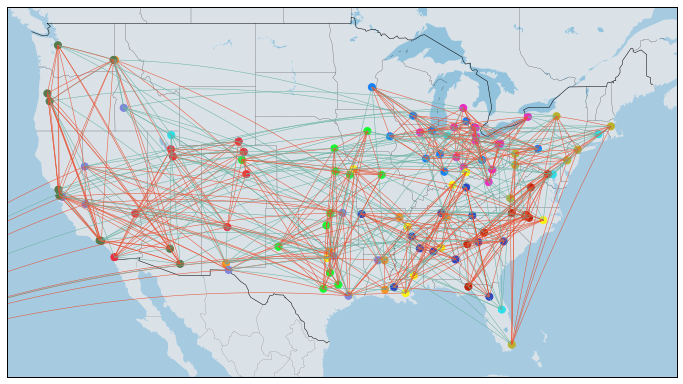

In [ ]:
def draw_map(graph,edge_df,node_df,nodes='all',size=[12,9]):
    plt.rcParams["figure.figsize"]=size
    m = Basemap(projection='merc',llcrnrlon=-127,llcrnrlat=23,urcrnrlon=-65,urcrnrlat=50,lat_ts=0,resolution='l',suppress_ticks=True)
    m.drawmapboundary(fill_color='#A6CAE0', linewidth=1)
    m.fillcontinents(color='#F1ECEB', alpha=0.7, lake_color='#76B6D8')
    m.drawcoastlines(linewidth=0.1, color="white")
    m.drawcountries(linewidth = 0.5)
    m.drawstates(linewidth = 0.1)

    map_df = pd.merge(edge_df,node_df[['Latitude','Longitude']]
                      .rename(columns={'Latitude':'src_lat','Longitude':'src_lon'}),
                      how='left',left_on='source',right_index=True)

    map_df = pd.merge(map_df,node_df[['Latitude','Longitude']]
                      .rename(columns={'Latitude':'trg_lat','Longitude':'trg_lon'}),
                      how='left',left_on='target',right_index=True)
    
    for idx, row in map_df.iterrows():
        if row.euclidean_dist > 0.5:
            if row.conference_game == 1:
                m.drawgreatcircle(row.src_lon, row.src_lat, row.trg_lon, row.trg_lat, linewidth=0.5, color='#E75132')
            else:
                m.drawgreatcircle(row.src_lon, row.src_lat, row.trg_lon, row.trg_lat, linewidth=0.5, color='#69b3a2')

    mx,my=m(node_df['Longitude'],node_df['Latitude'])
    node_map = mx.to_frame()
    node_map['Latitude'] = my
    location = dict(zip(node_df.index,node_map.values))

    cmap = {0:'#bd2309', 1:'#bbb12d',2:'#1480fa',3:'#14fa2f',4:'#faf214',
            5:'#2edfea',6:'#ea2ec4',7:'#ea2e40',8:'#577a4d',9:'#2e46c0',
            10:'#f59422',11:'#8086d9'}
    
    if nodes == 'all':
        nodes = graph.nodes()
    
    colors = [cmap[graph.nodes[n]['value']] for n in nodes]
    nx.draw_networkx_nodes(graph, location, nodelist=nodes,node_color=colors, node_size=50)

draw_map(G,edge_df,node_df,nodes='all')

### Train/Test Splits

In [ ]:
node_train, node_test = train_test_split(node_df,test_size=0.15,random_state=42)
edge_train = edge_df.loc[~((edge_df['source'].isin(node_test.index)) | (edge_df['target'].isin(node_test.index)))]
edge_test = edge_df.loc[(edge_df['source'].isin(node_test.index)) | (edge_df['target'].isin(node_test.index))]

### Add Bidirectional Duplication & Source-Target Index

In [ ]:
def bidirectional(edge_df):
    reverse_df = edge_df.rename(columns={'source':'target','target':'source'})
    reverse_df = reverse_df[edge_df.columns]
    reverse_df = pd.concat([edge_df, reverse_df], ignore_index=True, axis=0)
    return reverse_df

def create_adj_id(node_df,edge_df):
    node_df = node_df.reset_index().reset_index()
    edge_df = pd.merge(edge_df,node_df[['school','index']].rename(columns={"index":"source_id"}),
                       how='left',left_on='source',right_on='school').drop(columns=['school'])
    edge_df = pd.merge(edge_df,node_df[['school','index']].rename(columns={"index":"target_id"}),
                       how='left',left_on='target',right_on='school').drop(columns=['school'])
    
    edge_df.dropna(inplace=True)
    return node_df, edge_df

edge_full_adj = bidirectional(edge_df)
edge_train_adj = bidirectional(edge_train)

node_full_adj,edge_full_adj = create_adj_id(node_df,edge_full_adj)
node_train_adj,edge_train_adj = create_adj_id(node_train,edge_train_adj)

### Create Graph Tensors

In [ ]:
def create_graph_tensor(node_df,edge_df):
    graph_tensor = tfgnn.GraphTensor.from_pieces(
        node_sets = {
            "schools": tfgnn.NodeSet.from_fields(
                sizes = [len(node_df)],
                features ={
                    'Latitude': np.array(node_df['Latitude'], dtype='float32').reshape(len(node_df),1),
                    'Longitude': np.array(node_df['Longitude'], dtype='float32').reshape(len(node_df),1),
                    'Rank': np.array(node_df['Rank'], dtype='int32').reshape(len(node_df),1),
                    'Wins': np.array(node_df['Wins'], dtype='int32').reshape(len(node_df),1),
                    'Conf_wins': np.array(node_df['Conf_wins'], dtype='int32').reshape(len(node_df),1),
                    'conference': np.array(node_df.iloc[:,-12:], dtype='int32'),
                }),
        },
        edge_sets ={
            "games": tfgnn.EdgeSet.from_fields(
                sizes = [len(edge_df)],
                features = {
                    'name_sim_score': np.array(edge_df['name_sim_score'], dtype='float32').reshape(len(edge_df),1),
                    'euclidean_dist': np.array(edge_df['euclidean_dist'], dtype='float32').reshape(len(edge_df),1),
                    'conference_game': np.array(edge_df['conference_game'], dtype='int32').reshape(len(edge_df),1)
                },
                adjacency = tfgnn.Adjacency.from_indices(
                    source = ("schools", np.array(edge_df['source_id'], dtype='int32')),
                    target = ("schools", np.array(edge_df['target_id'], dtype='int32')),
                )),
        })
    return graph_tensor

full_tensor = create_graph_tensor(node_full_adj,edge_full_adj)
train_tensor = create_graph_tensor(node_train_adj,edge_train_adj)

### Create TensorFlow Datasets

In [ ]:
def node_batch_merge(graph):
    graph = graph.merge_batch_to_components()
    node_features = graph.node_sets['schools'].get_features_dict()
    edge_features = graph.edge_sets['games'].get_features_dict()
    
    label = node_features.pop('conference')
    _ = edge_features.pop('conference_game')
    
    new_graph = graph.replace_features(
        node_sets={'schools':node_features},
        edge_sets={'games':edge_features})
    return new_graph, label

def edge_batch_merge(graph):
    graph = graph.merge_batch_to_components()
    node_features = graph.node_sets['schools'].get_features_dict()
    edge_features = graph.edge_sets['games'].get_features_dict()
    
    _ = node_features.pop('conference')
    label = edge_features.pop('conference_game')
    
    new_graph = graph.replace_features(
        node_sets={'schools':node_features},
        edge_sets={'games':edge_features})
    return new_graph, label

def create_dataset(graph,function):
    dataset = tf.data.Dataset.from_tensors(graph)
    dataset = dataset.batch(32)
    return dataset.map(function)

#Node Datasets
full_node_dataset = create_dataset(full_tensor,node_batch_merge)
train_node_dataset = create_dataset(train_tensor,node_batch_merge)

#Edge Datasets
full_edge_dataset = create_dataset(full_tensor,edge_batch_merge)
train_edge_dataset = create_dataset(train_tensor,edge_batch_merge)

# Modeling
### Build Model Inputs

In [ ]:
def set_initial_node_state(node_set, node_set_name):
    features = [
        tf.keras.layers.Dense(32,activation="relu")(node_set['Latitude']),
        tf.keras.layers.Dense(32,activation="relu")(node_set['Longitude']),
        tf.keras.layers.Dense(32,activation="relu")(node_set['Rank']),
        tf.keras.layers.Dense(32,activation="relu")(node_set['Wins']),
        tf.keras.layers.Dense(32,activation="relu")(node_set['Conf_wins'])
    ]
    return tf.keras.layers.Concatenate()(features)

def set_initial_edge_state(edge_set, edge_set_name):
    features = [
        tf.keras.layers.Dense(32,activation="relu")(edge_set['name_sim_score']),
        tf.keras.layers.Dense(32,activation="relu")(edge_set['euclidean_dist'])
    ]
    return tf.keras.layers.Concatenate()(features)

graph_spec = train_node_dataset.element_spec[0]
input_graph = tf.keras.layers.Input(type_spec=graph_spec)

graph = tfgnn.keras.layers.MapFeatures(
    node_sets_fn=set_initial_node_state,
    edge_sets_fn=set_initial_edge_state
)(input_graph)

### Build Graph Updates

In [ ]:
def dense_layer(self,units=64,l2_reg=0.1,dropout=0.25,activation='relu'):
    regularizer = tf.keras.regularizers.l2(l2_reg)
    return tf.keras.Sequential([
        tf.keras.layers.Dense(units,
                              kernel_regularizer=regularizer,
                              bias_regularizer=regularizer),
        tf.keras.layers.Dropout(dropout)])
    
graph_updates = 3
for i in range(graph_updates):
    graph = tfgnn.keras.layers.GraphUpdate(
        node_sets = {
            'schools': tfgnn.keras.layers.NodeSetUpdate({
                'games': tfgnn.keras.layers.SimpleConv(
                    message_fn = dense_layer(32),
                    reduce_type="sum",
                    receiver_tag=tfgnn.TARGET)},
                tfgnn.keras.layers.NextStateFromConcat(
                    dense_layer(64)))})(graph)
    
    logits = tf.keras.layers.Dense(12,activation='softmax')(graph.node_sets["schools"][tfgnn.HIDDEN_STATE])

node_model = tf.keras.Model(input_graph, logits)

##### Compile model

In [ ]:
node_model.compile(
    tf.keras.optimizers.Adam(learning_rate=0.01),
    loss = 'categorical_crossentropy',
    metrics = ['categorical_accuracy']
)

node_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [()]                      0         
                                                                 
 map_features (MapFeatures)  ()                        448       
                                                                 
 graph_update (GraphUpdate)  ()                        34944     
                                                                 
 graph_update_1 (GraphUpdate  ()                       16512     
 )                                                               
                                                                 
 graph_update_2 (GraphUpdate  ()                       16512     
 )                                                               
                                                                 


 input.node_sets_2 (Instance  {'schools': ()}          0         
 Property)                                                       
                                                                 
 input._get_features_ref_9 (  {'hidden_state': (None,   0        
 InstanceProperty)           64)}                                
                                                                 
 dense_8 (Dense)             (None, 12)                780       
                                                                 
Total params: 69,196
Trainable params: 69,196
Non-trainable params: 0
_________________________________________________________________


### Train Model

In [ ]:
es = tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',mode='min',verbose=1,
        patience=10,restore_best_weights=True)

node_model.fit(train_node_dataset.repeat(),
               validation_data=full_node_dataset,
               steps_per_epoch=10,
               epochs=1000,
               callbacks=[es])

Epoch 1/1000


/usr/local/lib/python3.8/dist-packages/tensorflow/python/framework/indexed_slices.py:444: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/model/graph_update_2/node_set_update_2/simple_conv_2/Reshape_2:0", shape=(None,), dtype=int32), values=Tensor("gradient_tape/model/graph_update_2/node_set_update_2/simple_conv_2/Reshape_1:0", shape=(None, 64), dtype=float32), dense_shape=Tensor("gradient_tape/model/graph_update_2/node_set_update_2/simple_conv_2/Cast:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/tensorflow/python/framework/indexed_slices.py:444: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/model/graph_update_2/node_set_update_2/simple_conv_2/Reshape_4:0", shape=(None,), dtype=int32), values=Tensor("gradient_tape/model/graph_update_2/node_set_update_2/simple_conv_2/Reshape_3:0", shape

10/10 [==============================] - 2s 64ms/step - loss: 40930.2422 - categorical_accuracy: 0.1144 - val_loss: 23167.8379 - val_categorical_accuracy: 0.1130
Epoch 2/1000
10/10 [==============================] - 0s 25ms/step - loss: 8358.6797 - categorical_accuracy: 0.1701 - val_loss: 2796.5759 - val_categorical_accuracy: 0.3217
Epoch 3/1000
10/10 [==============================] - 0s 26ms/step - loss: 2768.8276 - categorical_accuracy: 0.2619 - val_loss: 2296.1165 - val_categorical_accuracy: 0.3043
Epoch 4/1000
10/10 [==============================] - 0s 25ms/step - loss: 1129.1870 - categorical_accuracy: 0.3928 - val_loss: 1131.2008 - val_categorical_accuracy: 0.4087
Epoch 5/1000
10/10 [==============================] - 0s 25ms/step - loss: 851.8091 - categorical_accuracy: 0.4062 - val_loss: 1206.8578 - val_categorical_accuracy: 0.5739
Epoch 6/1000
10/10 [==============================] - 0s 24ms/step - loss: 587.5136 - categorical_accuracy: 0.4918 - val_loss: 1049.9724 - val_cate

### Evaluate Results

In [ ]:
### Add raw prediction ####
yhat = node_model.predict(full_node_dataset)
yhat_df = node_full_adj.set_index('school').iloc[:,-12:].copy()
yhat_df.iloc[:,:] = yhat
    
### Classify max of softmax output ###
yhat_df = yhat_df.apply(lambda x: x == x.max(), axis=1).astype(int)
    
### Merge output back to single column ###
yhat_df = yhat_df.dot(yhat_df.columns).to_frame().rename(columns={0:"conf_yhat"})
yhat_df = yhat_df['conf_yhat'].str.replace('conf_', '').astype(int).to_frame()
yhat_df['conf_actual'] = node_full_adj.set_index('school')['conference']
    
### Filter down to test nodes ###
yhat_df = yhat_df.loc[yhat_df.index.isin(node_test.index)]
    
### Calculate accuracy ###
yhat_df['Accuracy'] = yhat_df['conf_yhat']==yhat_df['conf_actual']
print("node accuracy:",yhat_df['Accuracy'].mean())

1/1 [==============================] - 1s 579ms/step
node accuracy: 0.2222222222222222


##### The model trained successfully but they results are not great. Do not worry, accuracy will get much better when we tune the model later.
### Edge Model


In [ ]:
graph_spec = train_node_dataset.element_spec[0]
input_graph = tf.keras.layers.Input(type_spec=graph_spec)

graph = tfgnn.keras.layers.MapFeatures(
    node_sets_fn=set_initial_node_state,
    edge_sets_fn=set_initial_edge_state
)(input_graph)

graph_updates = 3
for i in range(graph_updates):
    graph = tfgnn.keras.layers.GraphUpdate(
        edge_sets = {'games': tfgnn.keras.layers.EdgeSetUpdate(
            next_state = tfgnn.keras.layers.NextStateFromConcat(
                dense_layer(64,activation='relu')))},
        node_sets = {
            'schools': tfgnn.keras.layers.NodeSetUpdate({
                'games': tfgnn.keras.layers.SimpleConv(
                    message_fn = dense_layer(32),
                    reduce_type="sum",
                    receiver_tag=tfgnn.TARGET)},
                tfgnn.keras.layers.NextStateFromConcat(
                    dense_layer(64)))})(graph)

    logits = tf.keras.layers.Dense(1,activation='sigmoid')(graph.edge_sets["games"][tfgnn.HIDDEN_STATE])

edge_model = tf.keras.Model(input_graph, logits)

### Compile Model

In [ ]:
edge_model.compile(
    tf.keras.optimizers.Adam(learning_rate=0.01),
    loss = 'binary_crossentropy',
    metrics = ['Accuracy']
)

edge_model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [()]                      0         
                                                                 
 map_features_1 (MapFeatures  ()                       448       
 )                                                               
                                                                 
 graph_update_3 (GraphUpdate  ()                       59584     
 )                                                               
                                                                 
 graph_update_4 (GraphUpdate  ()                       28864     
 )                                                               
                                                                 
 graph_update_5 (GraphUpdate  ()                       28864     
 )                                                         

### Train Model

In [ ]:
edge_model.fit(train_edge_dataset.repeat(),
               validation_data=full_edge_dataset,
               steps_per_epoch=10,
               epochs=1000,
               callbacks=[es])

Epoch 1/1000


/usr/local/lib/python3.8/dist-packages/tensorflow/python/framework/indexed_slices.py:444: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("Adam/gradients/concat_1:0", shape=(None,), dtype=int32), values=Tensor("Adam/gradients/concat:0", shape=(None, 64), dtype=float32), dense_shape=Tensor("gradient_tape/model_1/graph_update_5/edge_set_update_2/Cast:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/tensorflow/python/framework/indexed_slices.py:444: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/model_1/graph_update_4/edge_set_update_1/Reshape_1:0", shape=(None,), dtype=int32), values=Tensor("gradient_tape/model_1/graph_update_4/edge_set_update_1/Reshape:0", shape=(None, 64), dtype=float32), dense_shape=Tensor("gradient_tape/model_1/graph_update_4/edge_set_update_1/Cast:0", shape=(2,), dtype=int32))) to a d

10/10 [==============================] - 4s 146ms/step - loss: 5090.5635 - Accuracy: 0.5240 - val_loss: 2545.0366 - val_Accuracy: 0.3573
Epoch 2/1000
10/10 [==============================] - 1s 89ms/step - loss: 1067.2131 - Accuracy: 0.5416 - val_loss: 519.6085 - val_Accuracy: 0.6427
Epoch 3/1000
10/10 [==============================] - 1s 85ms/step - loss: 316.9055 - Accuracy: 0.5584 - val_loss: 263.8400 - val_Accuracy: 0.3573
Epoch 4/1000
10/10 [==============================] - 1s 135ms/step - loss: 143.1038 - Accuracy: 0.5406 - val_loss: 109.2459 - val_Accuracy: 0.6427
Epoch 5/1000
10/10 [==============================] - 0s 47ms/step - loss: 91.5465 - Accuracy: 0.5613 - val_loss: 56.6792 - val_Accuracy: 0.5212
Epoch 6/1000
10/10 [==============================] - 0s 48ms/step - loss: 71.9588 - Accuracy: 0.5741 - val_loss: 51.9688 - val_Accuracy: 0.6338
Epoch 7/1000
10/10 [==============================] - 0s 46ms/step - loss: 64.5156 - Accuracy: 0.5468 - val_loss: 58.5601 - val_Ac

### Evaluate Model

In [ ]:
yhat = edge_model.predict(full_edge_dataset)
yhat_df = edge_full_adj.copy().set_index(['source','target'])
yhat_df['conf_game_yhat'] = yhat.round(0)
yhat_df = yhat_df.loc[yhat_df.index.isin(
    edge_test.set_index(['source','target']).index)]
yhat_df['loss'] = abs(yhat_df['conference_game'] - yhat_df['conf_game_yhat'])
loss = yhat_df['loss'].mean()
print("edge accuracy:",1 - loss)

1/1 [==============================] - 16s 16s/step
edge accuracy: 0.563953488372093


##### Again, we successfully trained a model and will worry about accuracy when we get to model tunning
# Troubleshooting Techniques
### Create Graph Spec

In [ ]:
graph_spec = tfgnn.GraphTensorSpec.from_piece_specs(
    context_spec = tfgnn.ContextSpec.from_field_specs(
        features_spec ={
            #Added as an example for context problems
            #"conf_rank": tf.TensorSpec(shape=(None,1), dtype=tf.float32),
        }),
    node_sets_spec={
        'schools':
            tfgnn.NodeSetSpec.from_field_specs(
                features_spec={
                    'Latitude': tf.TensorSpec((None, 1), tf.float32),
                    'Longitude': tf.TensorSpec((None, 1), tf.float32),
                    'Rank': tf.TensorSpec((None, 1), tf.int32),
                    'Wins': tf.TensorSpec((None, 1), tf.int32),
                    'Conf_wins': tf.TensorSpec((None, 1), tf.int32),
                    'conference': tf.TensorSpec((None, 12), tf.int32)
                },
                sizes_spec=tf.TensorSpec((1,), tf.int32))
    },
    edge_sets_spec={
        'games':
            tfgnn.EdgeSetSpec.from_field_specs(
                features_spec={
                    'name_sim_score': tf.TensorSpec((None, 1), tf.float32),
                    'euclidean_dist': tf.TensorSpec((None, 1), tf.float32),
                    'conference_game': tf.TensorSpec((None, 1), tf.int32)
                },
                sizes_spec=tf.TensorSpec((1,), tf.int32),
                adjacency_spec=tfgnn.AdjacencySpec.from_incident_node_sets(
                    'schools', 'schools'))
    })

### Test Graph Spec

In [ ]:
graph_spec.is_compatible_with(full_tensor)

True

### Build Model From Graph Spec

In [ ]:
input_graph = tf.keras.layers.Input(type_spec=graph_spec)

graph = tfgnn.keras.layers.MapFeatures(
    node_sets_fn=set_initial_node_state,
    edge_sets_fn=set_initial_edge_state
)(input_graph)

graph_updates = 3
for i in range(graph_updates):
    graph = tfgnn.keras.layers.GraphUpdate(
        edge_sets = {'games': tfgnn.keras.layers.EdgeSetUpdate(
            next_state = tfgnn.keras.layers.NextStateFromConcat(
                dense_layer(64,activation='relu')))},
        node_sets = {
            'schools': tfgnn.keras.layers.NodeSetUpdate({
                'games': tfgnn.keras.layers.SimpleConv(
                    message_fn = dense_layer(32),
                    reduce_type="sum",
                    receiver_tag=tfgnn.TARGET)},
                tfgnn.keras.layers.NextStateFromConcat(
                    dense_layer(64)))})(graph)

    logits = tf.keras.layers.Dense(1,activation='sigmoid')(graph.edge_sets["games"][tfgnn.HIDDEN_STATE])

test_model = tf.keras.Model(input_graph, logits)

### Create Random Graph From Graph Spec

In [ ]:
random_graph = tfgnn.random_graph_tensor(graph_spec)
print("Nodes:",random_graph.node_sets['schools'].features)
print("Edges:",random_graph.edge_sets['games'].features)
print("Context:",random_graph.context.features)

Nodes: {'Latitude': <tf.Tensor: shape=(5, 1), dtype=float32, numpy=
array([[0.0190109 ],
       [0.69601953],
       [0.7011608 ],
       [0.53219724],
       [0.39926624]], dtype=float32)>, 'Longitude': <tf.Tensor: shape=(5, 1), dtype=float32, numpy=
array([[0.92046523],
       [0.29431486],
       [0.93218577],
       [0.72809124],
       [0.8630272 ]], dtype=float32)>, 'Rank': <tf.Tensor: shape=(5, 1), dtype=int32, numpy=
array([[18],
       [44],
       [37],
       [27],
       [13]], dtype=int32)>, 'Wins': <tf.Tensor: shape=(5, 1), dtype=int32, numpy=
array([[68],
       [91],
       [15],
       [65],
       [22]], dtype=int32)>, 'Conf_wins': <tf.Tensor: shape=(5, 1), dtype=int32, numpy=
array([[82],
       [71],
       [34],
       [50],
       [73]], dtype=int32)>, 'conference': <tf.Tensor: shape=(5, 12), dtype=int32, numpy=
array([[67, 79, 51, 28, 96, 63, 68, 41, 76, 87, 68, 25],
       [93, 37, 45, 11, 23, 17, 31, 33, 26, 65, 84, 69],
       [71, 61, 89, 83, 96, 74, 84, 61, 

# Parameter Tuning
### Build Class

In [ ]:
class GCNN:
    def __init__(self,params):
        self.params = params
        
    def set_initial_node_state(self, node_set, node_set_name):
        features = [
            tf.keras.layers.Dense(self.params['feature_dim'],activation="relu")(node_set['Latitude']),
            tf.keras.layers.Dense(self.params['feature_dim'],activation="relu")(node_set['Longitude']),
            tf.keras.layers.Dense(self.params['feature_dim'],activation="relu")(node_set['Rank']),
            tf.keras.layers.Dense(self.params['feature_dim'],activation="relu")(node_set['Wins']),
            tf.keras.layers.Dense(self.params['feature_dim'],activation="relu")(node_set['Conf_wins'])
        ]
        return tf.keras.layers.Concatenate()(features)

    def set_initial_edge_state(self, edge_set, edge_set_name):
        features = [
            tf.keras.layers.Dense(self.params['feature_dim'],activation="relu")(edge_set['name_sim_score']),
            tf.keras.layers.Dense(self.params['feature_dim'],activation="relu")(edge_set['euclidean_dist'])
        ]
        return tf.keras.layers.Concatenate()(features)

    def dense_layer(self,units=64):
        regularizer = tf.keras.regularizers.l2(self.params['l2_reg'])
        return tf.keras.Sequential([
            tf.keras.layers.Dense(units,
                                  kernel_regularizer=regularizer,
                                  bias_regularizer=regularizer,
                                  activation='relu'),
            tf.keras.layers.Dropout(self.params['dropout'])])

    def build_model(self):
        input_graph = tf.keras.layers.Input(type_spec=self.params['trainset'].element_spec[0])
        graph = tfgnn.keras.layers.MapFeatures(
            node_sets_fn=self.set_initial_node_state,
            edge_sets_fn=self.set_initial_edge_state
        )(input_graph)
        
        if self.params['loss']=='categorical_crossentropy':
            for i in range(self.params['graph_updates']):
                graph = tfgnn.keras.layers.GraphUpdate(
                    node_sets = {
                        'schools': tfgnn.keras.layers.NodeSetUpdate({
                            'games': tfgnn.keras.layers.SimpleConv(
                                message_fn = self.dense_layer(self.params['message_dim']),
                                reduce_type="sum",
                                receiver_tag=tfgnn.TARGET)},
                            tfgnn.keras.layers.NextStateFromConcat(
                                self.dense_layer(self.params['next_state_dim'])))})(graph)
            logits = tf.keras.layers.Dense(12,activation='softmax')(graph.node_sets["schools"][tfgnn.HIDDEN_STATE])
        else:
            for i in range(self.params['graph_updates']):
                graph = tfgnn.keras.layers.GraphUpdate(
                    edge_sets = {'games': tfgnn.keras.layers.EdgeSetUpdate(
                        next_state = tfgnn.keras.layers.NextStateFromConcat(
                            self.dense_layer(self.params['next_state_dim'])))},
                    node_sets = {
                        'schools': tfgnn.keras.layers.NodeSetUpdate({
                            'games': tfgnn.keras.layers.SimpleConv(
                                message_fn = self.dense_layer(self.params['message_dim']),
                                reduce_type="sum",
                                receiver_tag=tfgnn.TARGET)},
                            tfgnn.keras.layers.NextStateFromConcat(
                                self.dense_layer(self.params['next_state_dim'])))})(graph)
            logits = tf.keras.layers.Dense(1,activation='sigmoid')(graph.edge_sets["games"][tfgnn.HIDDEN_STATE])
        return tf.keras.Model(input_graph, logits)
        
    def train_model(self,trial=True):
        model = self.build_model()
        
        model.compile(tf.keras.optimizers.Adam(learning_rate=self.params['learning_rate']),
                      loss=self.params['loss'],
                      metrics=['Accuracy'])
        
        callbacks = [tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                      mode='min',
                                                      verbose=1,
                                                      patience=self.params['patience'],
                                                      restore_best_weights=True)]
        
        model.fit(self.params['trainset'].repeat(),
                  validation_data=self.params['full_dataset'],
                  steps_per_epoch=self.params['steps_per_epoch'],
                  epochs=self.params['epochs'],
                  verbose=0,
                  callbacks = callbacks)
        
        loss = self.evaluate_model(model,trial=trial)
            
        if trial == True:
            sys.stdout.flush()
            hypt_params = {
                'graph_updates':self.params['graph_updates'],
                'feature_dim':self.params['feature_dim'],
                'next_state_dim':self.params['next_state_dim'],
                'message_dim':self.params['message_dim'],
                'l2_reg':self.params['l2_reg'],
                'dropout':self.params['dropout'],
                'learning_rate':self.params['learning_rate']}
            print(hypt_params,'loss:',loss)
            return {'loss': loss, 'status': STATUS_OK}
        else:
            print('loss:',loss)
            return model
        
    def evaluate_model(self,model,trial=True):
        if self.params['loss'] == 'categorical_crossentropy':
            yhat = model.predict(full_node_dataset)
            yhat_df = node_full_adj.set_index('school').iloc[:,-12:].copy()
            yhat_df.iloc[:,:] = yhat
            yhat_df = yhat_df.apply(lambda x: x == x.max(), axis=1).astype(int)
            yhat_df = yhat_df.dot(yhat_df.columns).to_frame().rename(columns={0:"conf_yhat"})
            yhat_df = yhat_df['conf_yhat'].str.replace('conf_', '').astype(int).to_frame()
            yhat_df['conf_actual'] = node_full_adj.set_index('school')['conference']
            yhat_df['Accuracy'] = yhat_df['conf_yhat']==yhat_df['conf_actual']
            if trial == False:
                print("full dataset accuracy:",yhat_df['Accuracy'].mean())
                print('Conference Actual Full Dataset')
                G_yhat = G.copy()
                draw_map(G_yhat,edge_df,node_df,nodes=list(yhat_df.index),size=[8,6])
                plt.show()
                print('Predicted Conference Full Dataset')
                nx.set_node_attributes(G_yhat, dict(zip(yhat_df.index,yhat_df.conf_yhat)), 'value')
                draw_map(G_yhat,edge_df,node_df,nodes=list(yhat_df.index),size=[8,6])
                plt.show()

            yhat_df = yhat_df.loc[yhat_df.index.isin(node_test.index)]
            loss = 1 - yhat_df['Accuracy'].mean()
            if trial==False:
                print('Conference Actual Holdout Dataset')
                G_yhat = G.copy()
                draw_map(G_yhat,edge_df,node_df,nodes=list(yhat_df.index),size=[8,6])
                plt.show()
                print('Predicted Conference Holdout Dataset')
                nx.set_node_attributes(G_yhat, dict(zip(yhat_df.index,yhat_df.conf_yhat)), 'value')
                draw_map(G_yhat,edge_df,node_df,nodes=list(yhat_df.index),size=[8,6])
                plt.show()
        else:
            yhat = model.predict(full_edge_dataset)
            yhat_df = edge_full_adj.copy().set_index(['source','target'])
            yhat_df['conf_game_yhat'] = yhat.round(0)
            yhat_df = yhat_df.loc[yhat_df.index.isin(
                edge_test.set_index(['source','target']).index)]
            yhat_df['loss'] = abs(yhat_df['conference_game'] - yhat_df['conf_game_yhat'])
            loss = yhat_df['loss'].mean()
        return loss

### Tune Node Model
##### Due to colabs limited resources, I will do a short trial here to show how it works. I would recommend doing 70-100 max_evals

In [ ]:
params = {
    ### Tuning parameters ###
    'graph_updates': hp.choice('graph_updates',[2,3,4]),
    'feature_dim': hp.choice('feature_dim',[16,32,64,128]),
    'message_dim': hp.choice('message_dim',[16,32,64,128]),
    'next_state_dim': hp.choice('next_state_dim',[16,32,64,128]),
    'l2_reg': hp.uniform('l2_reg',0.0,0.3),
    'dropout': hp.choice('dropout',[0,0.125,0.25,0.375,0.5]),
    'learning_rate': hp.uniform('learning_rate',0.0,0.1),
    
    ### Static parameters ###
    'loss': 'categorical_crossentropy',
    'epochs': 1000,
    'steps_per_epoch':10, ### This could also be a tuned parameter
    'patience':10,
    'trainset':train_node_dataset,
    'full_dataset':full_node_dataset
}

def tune_model(params):
    return GCNN(params).train_model()

best_node = fmin(tune_model, params, algo=tpe.suggest,
                 max_evals=2, trials=Trials())

  0%|          | 0/2 [00:00<?, ?it/s, best loss: ?]

/usr/local/lib/python3.8/dist-packages/tensorflow/python/framework/indexed_slices.py:444: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/model_2/graph_update_7/node_set_update_7/simple_conv_7/Reshape_2:0", shape=(None,), dtype=int32), values=Tensor("gradient_tape/model_2/graph_update_7/node_set_update_7/simple_conv_7/Reshape_1:0", shape=(None, 64), dtype=float32), dense_shape=Tensor("gradient_tape/model_2/graph_update_7/node_set_update_7/simple_conv_7/Cast:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  warnings.warn(

/usr/local/lib/python3.8/dist-packages/tensorflow/python/framework/indexed_slices.py:444: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/model_2/graph_update_7/node_set_update_7/simple_conv_7/Reshape_4:0", shape=(None,), dtype=int32), values=Tensor("gradient_tape/model_2/graph_update_7/node_set_update_7/simple_conv_7/Reshape_

Restoring model weights from the end of the best epoch: 183.

Epoch 193: early stopping

1/1 [==============================] - 0s 245ms/step

{'graph_updates': 2, 'feature_dim': 32, 'next_state_dim': 64, 'message_dim': 64, 'l2_reg': 0.20607069970357286, 'dropout': 0, 'learning_rate': 0.07801349331608774}
loss:
1.0
 50%|█████     | 1/2 [00:49<00:49, 49.61s/it, best loss: 1.0]

/usr/local/lib/python3.8/dist-packages/tensorflow/python/framework/indexed_slices.py:444: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/model_3/graph_update_9/node_set_update_9/simple_conv_9/Reshape_2:0", shape=(None,), dtype=int32), values=Tensor("gradient_tape/model_3/graph_update_9/node_set_update_9/simple_conv_9/Reshape_1:0", shape=(None, 64), dtype=float32), dense_shape=Tensor("gradient_tape/model_3/graph_update_9/node_set_update_9/simple_conv_9/Cast:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  warnings.warn(

/usr/local/lib/python3.8/dist-packages/tensorflow/python/framework/indexed_slices.py:444: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/model_3/graph_update_9/node_set_update_9/simple_conv_9/Reshape_4:0", shape=(None,), dtype=int32), values=Tensor("gradient_tape/model_3/graph_update_9/node_set_update_9/simple_conv_9/Reshape_

Restoring model weights from the end of the best epoch: 69.

Epoch 79: early stopping

1/1 [==============================] - 19s 19s/step

{'graph_updates': 2, 'feature_dim': 64, 'next_state_dim': 64, 'message_dim': 64, 'l2_reg': 0.18812445292234972, 'dropout': 0.375, 'learning_rate': 0.03612839213819885}
loss:
0.7222222222222222
100%|██████████| 2/2 [01:33<00:00, 46.64s/it, best loss: 0.7222222222222222]


### Train Model
##### Best parameters from hyperopt run on my personal computer

/usr/local/lib/python3.8/dist-packages/tensorflow/python/framework/indexed_slices.py:444: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/model_13/graph_update_33/node_set_update_33/simple_conv_33/Reshape_2:0", shape=(None,), dtype=int32), values=Tensor("gradient_tape/model_13/graph_update_33/node_set_update_33/simple_conv_33/Reshape_1:0", shape=(None, 64), dtype=float32), dense_shape=Tensor("gradient_tape/model_13/graph_update_33/node_set_update_33/simple_conv_33/Cast:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/tensorflow/python/framework/indexed_slices.py:444: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/model_13/graph_update_33/node_set_update_33/simple_conv_33/Reshape_4:0", shape=(None,), dtype=int32), values=Tensor("gradient_tape/model_13/graph_update_33/node_set_update_33/simp

Restoring model weights from the end of the best epoch: 151.
Epoch 161: early stopping
1/1 [==============================] - 0s 279ms/step
full dataset accuracy: 0.8782608695652174
Conference Actual Full Dataset


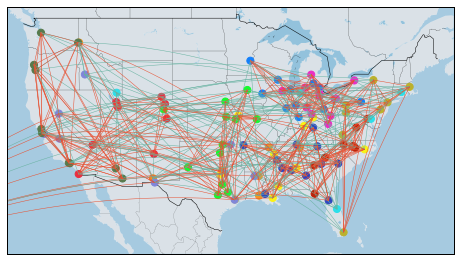

Predicted Conference Full Dataset


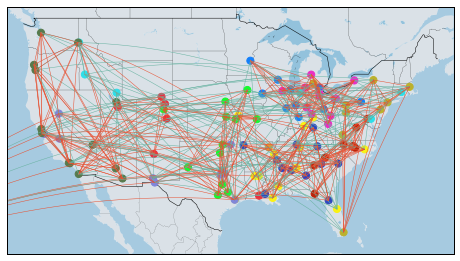

Conference Actual Holdout Dataset


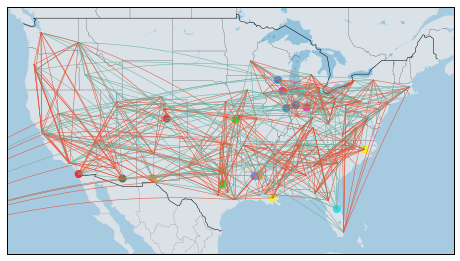

Predicted Conference Holdout Dataset


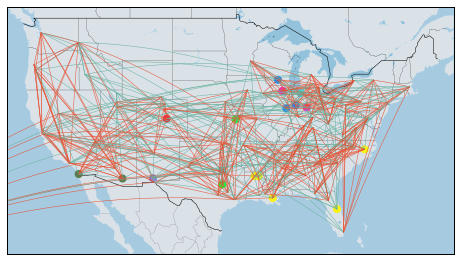

loss: 0.33333333333333337


In [ ]:
top_params = {
    'graph_updates': 2,
    'feature_dim': 32,
    'next_state_dim': 64,
    'message_dim': 64,
    'l2_reg': 0.24,
    'dropout': 0.25,
    'learning_rate': 0.003
}

node_params = params
for param, value in top_params.items():
    node_params[param] = value

node_model = GCNN(node_params).train_model(trial=False)

### Tune Edge Model
##### Again, doing a limited trial due to colab resources

In [ ]:
params['loss'] = 'binary_crossentropy'
params['trainset'] = train_edge_dataset
params['full_dataset'] = full_edge_dataset

best_edge = fmin(tune_model, params, algo=tpe.suggest,
                 max_evals=2, trials=Trials())

  0%|          | 0/2 [00:00<?, ?it/s, best loss: ?]

/usr/local/lib/python3.8/dist-packages/tensorflow/python/framework/indexed_slices.py:444: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("Adam/gradients/concat_1:0", shape=(None,), dtype=int32), values=Tensor("Adam/gradients/concat:0", shape=(None, 64), dtype=float32), dense_shape=Tensor("gradient_tape/model_17/graph_update_41/edge_set_update_7/Cast:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  warnings.warn(

/usr/local/lib/python3.8/dist-packages/tensorflow/python/framework/indexed_slices.py:444: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/model_17/graph_update_40/edge_set_update_6/Reshape_1:0", shape=(None,), dtype=int32), values=Tensor("gradient_tape/model_17/graph_update_40/edge_set_update_6/Reshape:0", shape=(None, 160), dtype=float32), dense_shape=Tensor("gradient_tape/model_17/graph_update_40/edge_set_update_6/Cast:0", shape=(2,), dtype=int32

Restoring model weights from the end of the best epoch: 80.

Epoch 90: early stopping

1/1 [==============================] - 1s 756ms/step

{'graph_updates': 2, 'feature_dim': 32, 'next_state_dim': 64, 'message_dim': 64, 'l2_reg': 0.24, 'dropout': 0.25, 'learning_rate': 0.003}
loss:
0.14534883720930233
 50%|█████     | 1/2 [00:34<00:34, 34.23s/it, best loss: 0.14534883720930233]

/usr/local/lib/python3.8/dist-packages/tensorflow/python/framework/indexed_slices.py:444: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("Adam/gradients/concat_1:0", shape=(None,), dtype=int32), values=Tensor("Adam/gradients/concat:0", shape=(None, 64), dtype=float32), dense_shape=Tensor("gradient_tape/model_18/graph_update_43/edge_set_update_9/Cast:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  warnings.warn(

/usr/local/lib/python3.8/dist-packages/tensorflow/python/framework/indexed_slices.py:444: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/model_18/graph_update_42/edge_set_update_8/Reshape_1:0", shape=(None,), dtype=int32), values=Tensor("gradient_tape/model_18/graph_update_42/edge_set_update_8/Reshape:0", shape=(None, 160), dtype=float32), dense_shape=Tensor("gradient_tape/model_18/graph_update_42/edge_set_update_8/Cast:0", shape=(2,), dtype=int32

Restoring model weights from the end of the best epoch: 105.

Epoch 115: early stopping

1/1 [==============================] - 11s 11s/step

{'graph_updates': 2, 'feature_dim': 32, 'next_state_dim': 64, 'message_dim': 64, 'l2_reg': 0.24, 'dropout': 0.25, 'learning_rate': 0.003}
loss:
0.13372093023255813
100%|██████████| 2/2 [01:18<00:00, 39.14s/it, best loss: 0.13372093023255813]


### Train Model
##### Best parameters from hyperopt run on my personal computer

In [ ]:
### Perameters from my hyperopt run ###
best_edge = {
    'graph_updates': 4,
    'feature_dim': 64,
    'next_state_dim': 32,
    'message_dim': 128,
    'l2_reg': 0.095,
    'dropout': 0,
    'learning_rate': 0.0025
}

edge_params = params
for param, value in best_edge.items():
    edge_params[param] = value
    
edge_model = GCNN(edge_params).train_model(trial=False)

/usr/local/lib/python3.8/dist-packages/tensorflow/python/framework/indexed_slices.py:444: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("Adam/gradients/concat_1:0", shape=(None,), dtype=int32), values=Tensor("Adam/gradients/concat:0", shape=(None, 32), dtype=float32), dense_shape=Tensor("gradient_tape/model_28/graph_update_61/edge_set_update_14/Cast:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/tensorflow/python/framework/indexed_slices.py:444: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/model_28/graph_update_60/edge_set_update_13/Reshape_1:0", shape=(None,), dtype=int32), values=Tensor("gradient_tape/model_28/graph_update_60/edge_set_update_13/Reshape:0", shape=(None, 32), dtype=float32), dense_shape=Tensor("gradient_tape/model_28/graph_update_60/edge_set_update_13/Cast:0", shape=(2,), dtype=int

Restoring model weights from the end of the best epoch: 368.
Epoch 378: early stopping
1/1 [==============================] - 17s 17s/step
loss: 0.13953488372093023


##### 86% Accuracy is much better than the previously untunned model